## Percobaan 3

prepro

In [37]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Data Loading

In [38]:
data = []
labels = []
file_name = []

for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        if img is not None:
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)  # Konversi ke grayscale
            img = cv.resize(img, (150, 150))           # Resize ke ukuran tetap
            img = img.astype(np.uint8)                 # Tipe data sesuai

            data.append(img)
            labels.append(sub_folder)
            file_name.append(filename)

data = np.array(data)
labels = np.array(labels)


## Data Preparation

### Define Preprocessing

In [39]:
def histogram_equalization(img_gray):
    hist, bins = np.histogram(img_gray.flatten(), bins=256, range=[0,255])
    cdf = hist.cumsum()
    cdf_normalized = cdf * 255 / cdf[-1]
    img_eq = np.interp(img_gray.flatten(), bins[:-1], cdf_normalized)
    return img_eq.reshape(img_gray.shape).astype(np.uint8)

def median(arr):
    n = len(arr)
    sorted_arr = sorted(arr)
    if n % 2 == 0:
        median1 = sorted_arr[n//2]
        median2 = sorted_arr[n//2 - 1]
        median = (median1 + median2)/2
    else:
        median = sorted_arr[n//2]
        
    return median

def filter_median(image, kernel):
    # mengambil nilai shape dari variabel image dan kernel 
    heightImage, widthImage = image.shape
    heightKernel, widthKernel = kernel.shape
    # melakukan perhitungan untuk mencari nilai tengah 
    heigthCenter = int((heightKernel - 1)/2)
    widthCenter = int((widthKernel - 1)/2)

    # proses padding 
    leftPad = widthCenter
    rightPad = widthKernel - widthCenter
    topPad = heigthCenter
    botPad = heightKernel - heigthCenter
    image = np.pad(image, ((leftPad, rightPad), (topPad, botPad)), mode='edge')

    result = np.zeros([heightImage, widthImage])
    # proses konvolusi
    for i in range(heightImage):
         for j in range(widthImage):
             temp = np.zeros(len(kernel)*len(kernel))
             indeks = 0
             for k in range(heightKernel):
                 for l in range(widthKernel):
                     temp[indeks] += image[i+k,j+l]
                     indeks+=1
                     result[i,j] = median(temp)
             
    return np.clip(result, 0, 255).astype(np.uint8)

def filter_image(image, kernel):
    HtoInt = int((kernel.shape[0] - 1) / 2)
    WtoInt = int((kernel.shape[1] - 1) / 2)
    PaddingKanan = kernel.shape[1] - WtoInt
    PaddingBawah = kernel.shape[0] - HtoInt
    result = np.zeros(image.shape)
    imgs = np.pad(image, ((HtoInt, PaddingBawah), (WtoInt, PaddingKanan)), mode='edge')
    
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            pixel = 0
            for k in range(kernel.shape[0]):
                for l in range(kernel.shape[1]):
                    pixel += imgs[i + k, j + l] * kernel[k, l]
            result[i, j] = pixel
            
    return result

## Preprocessing

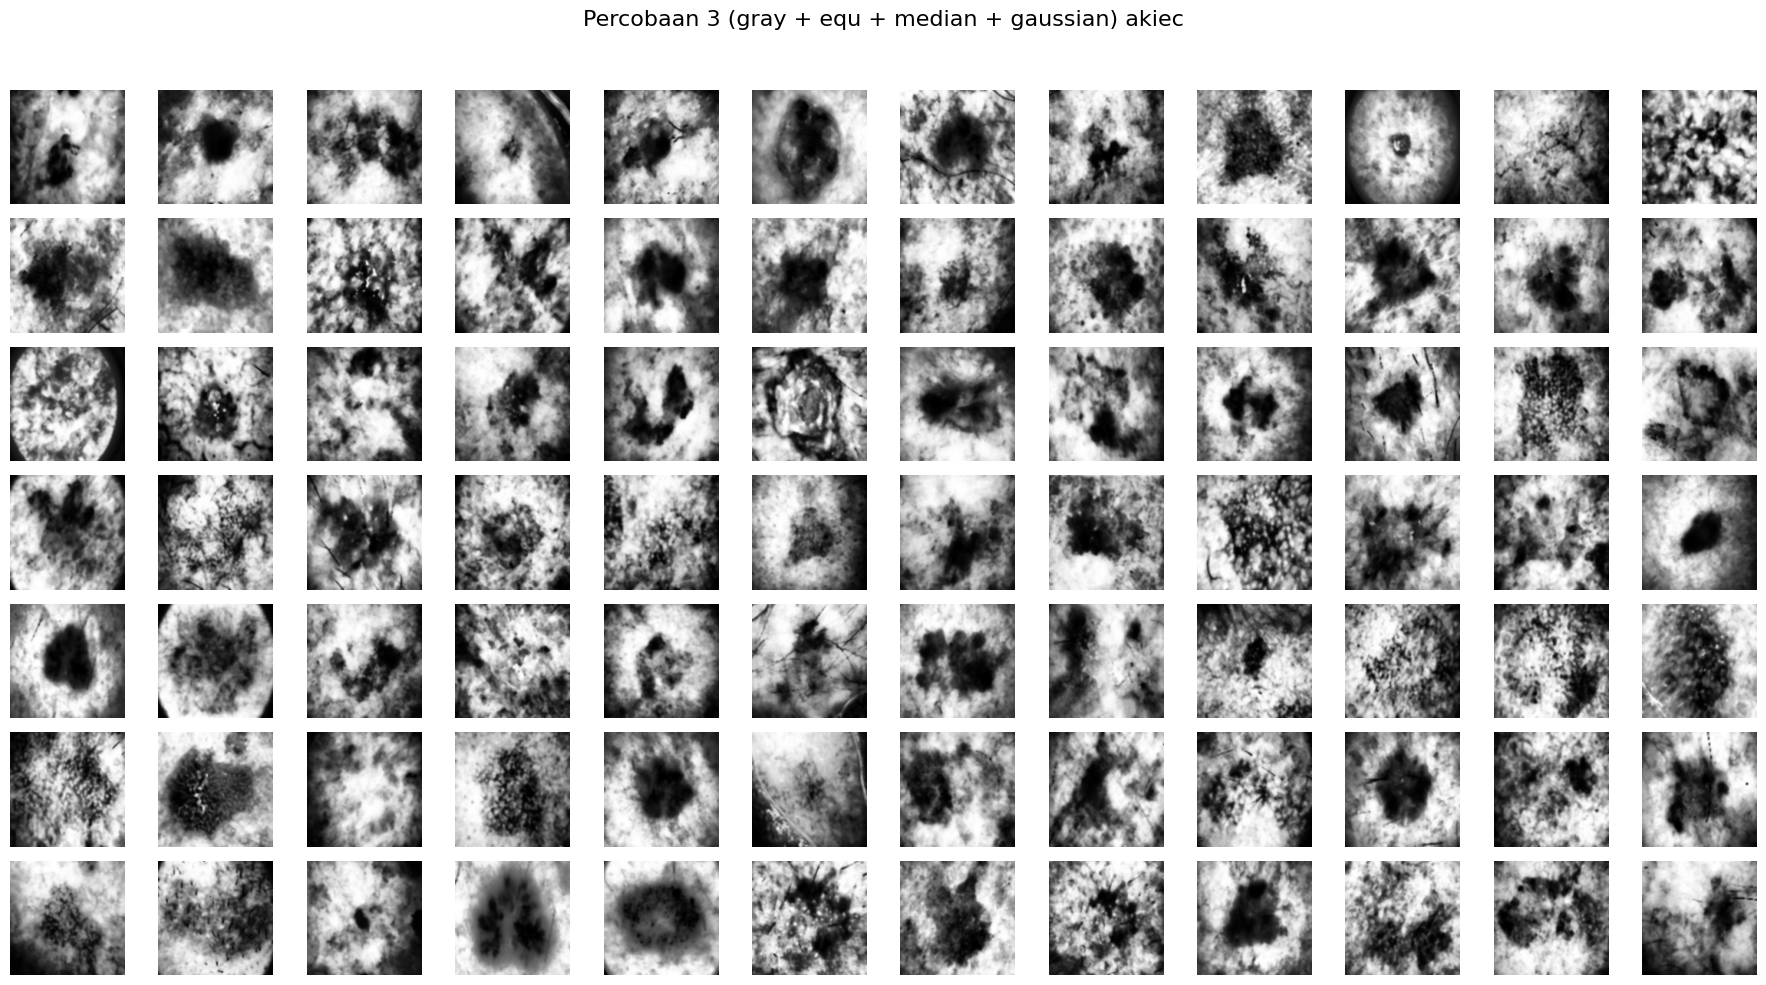

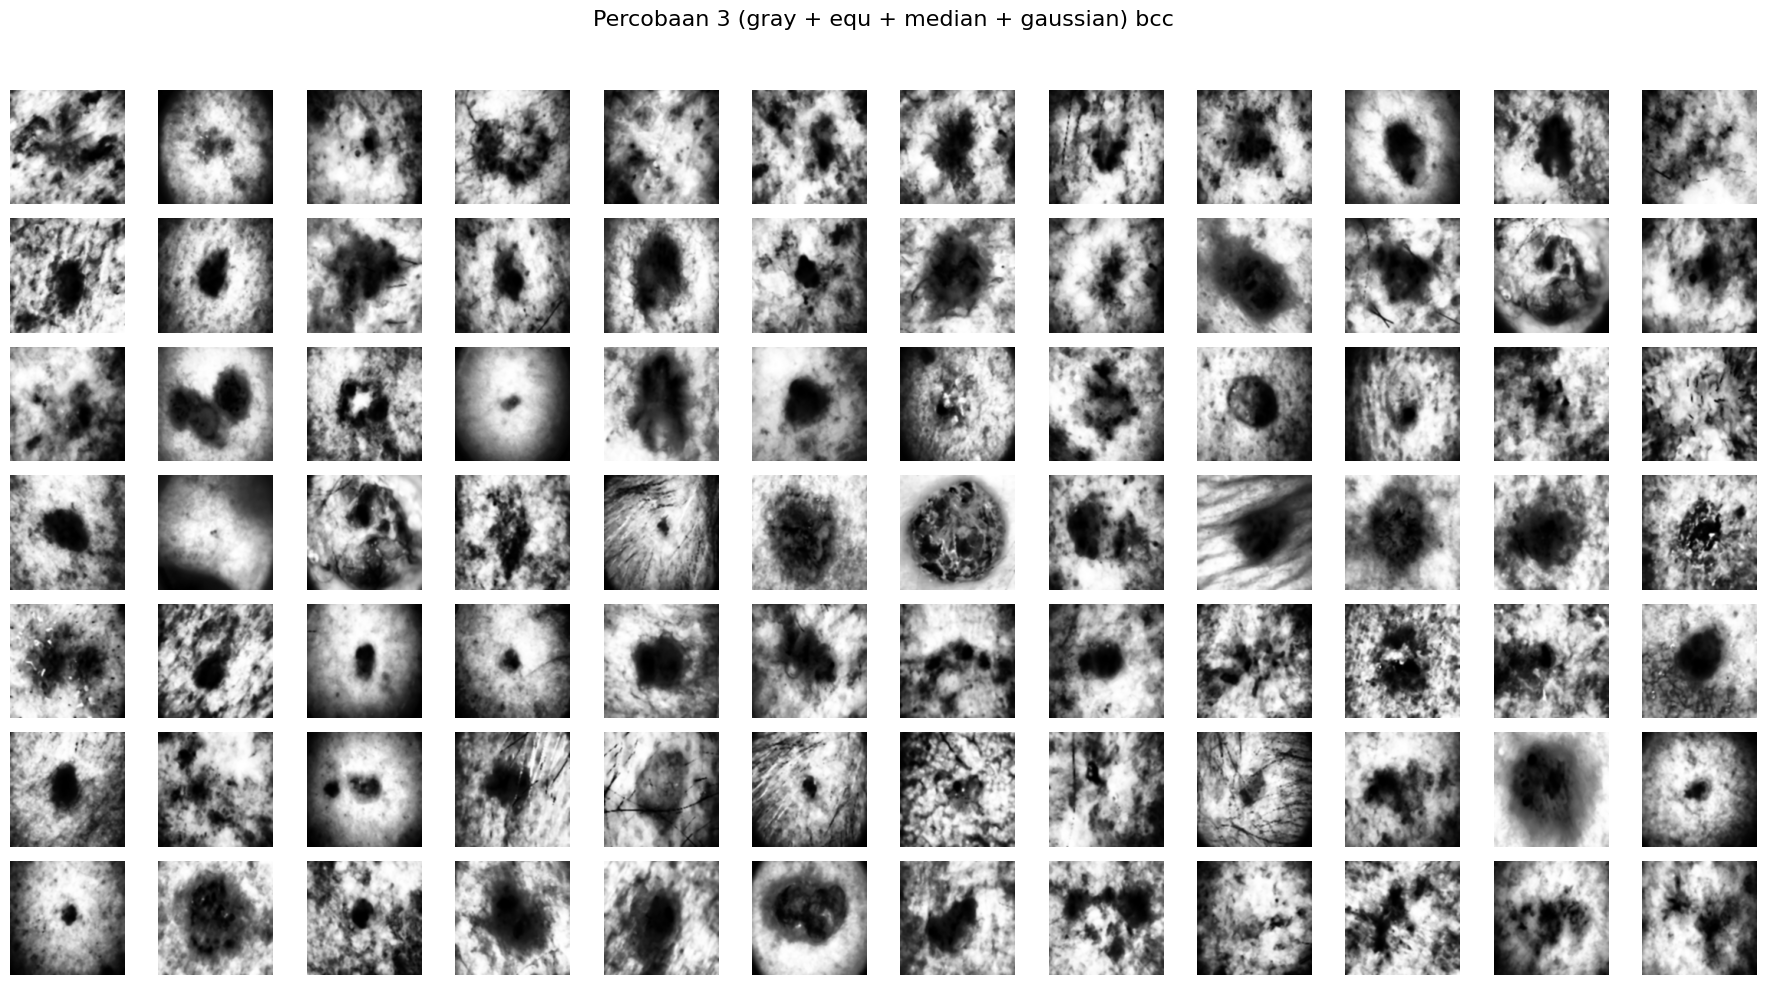

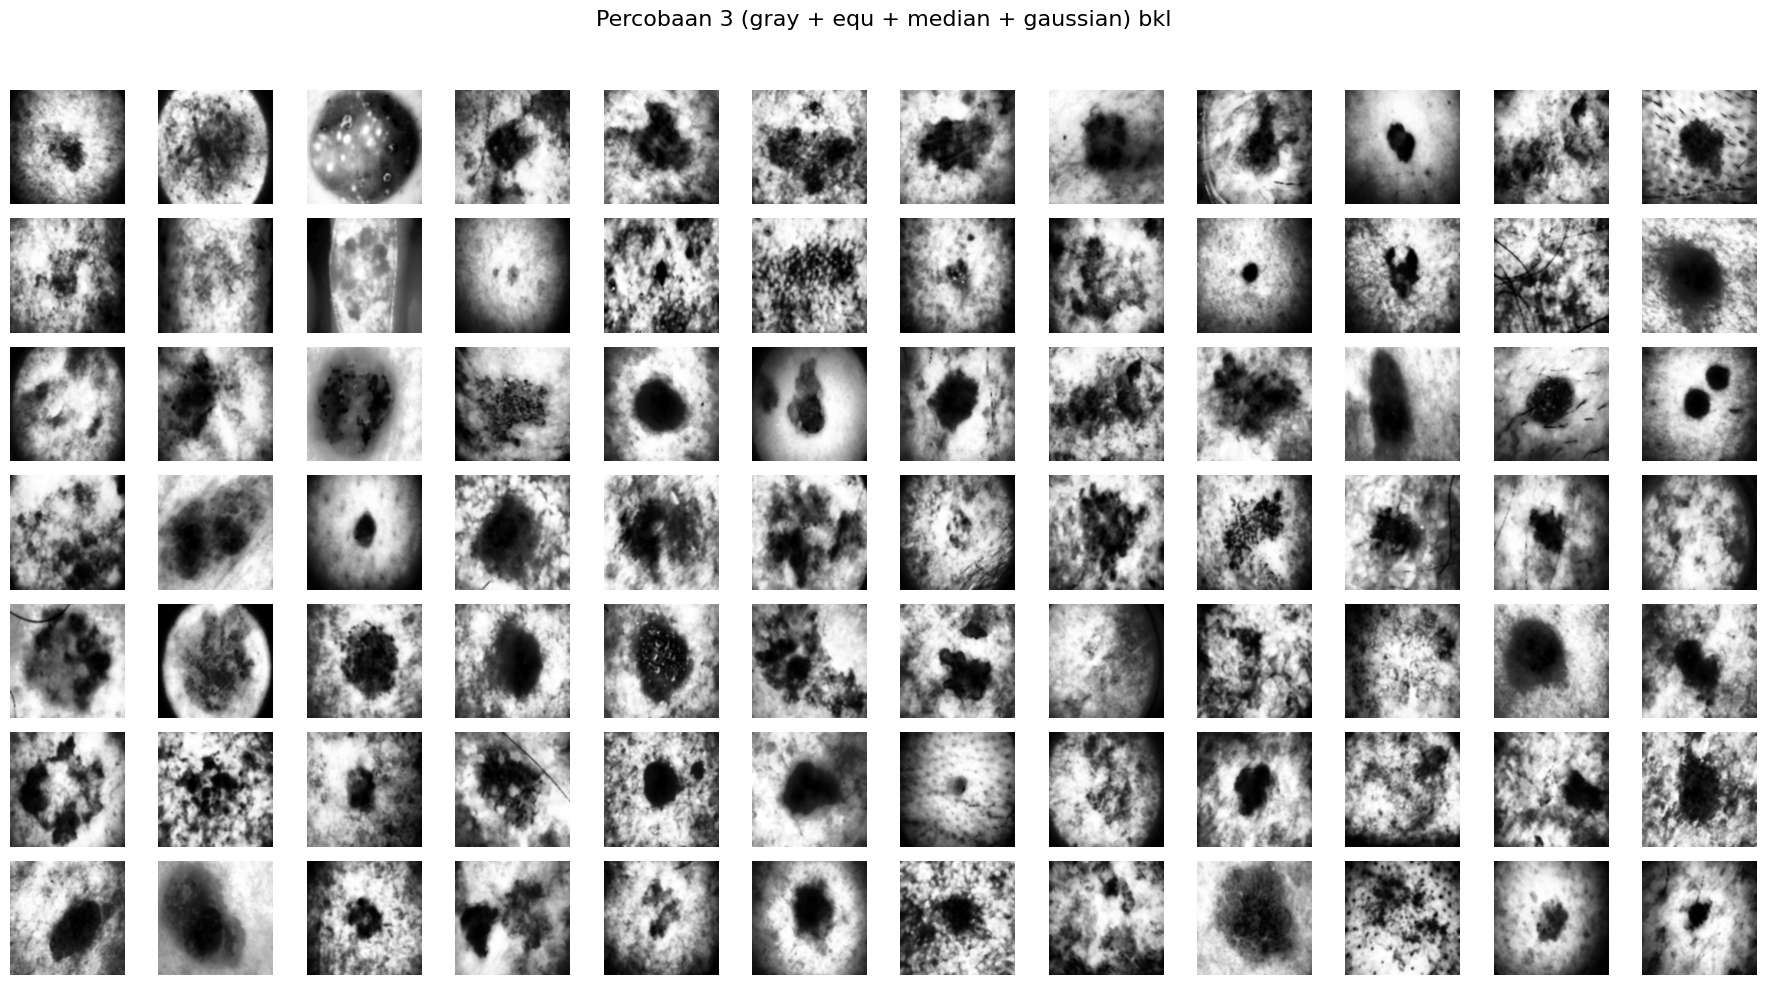

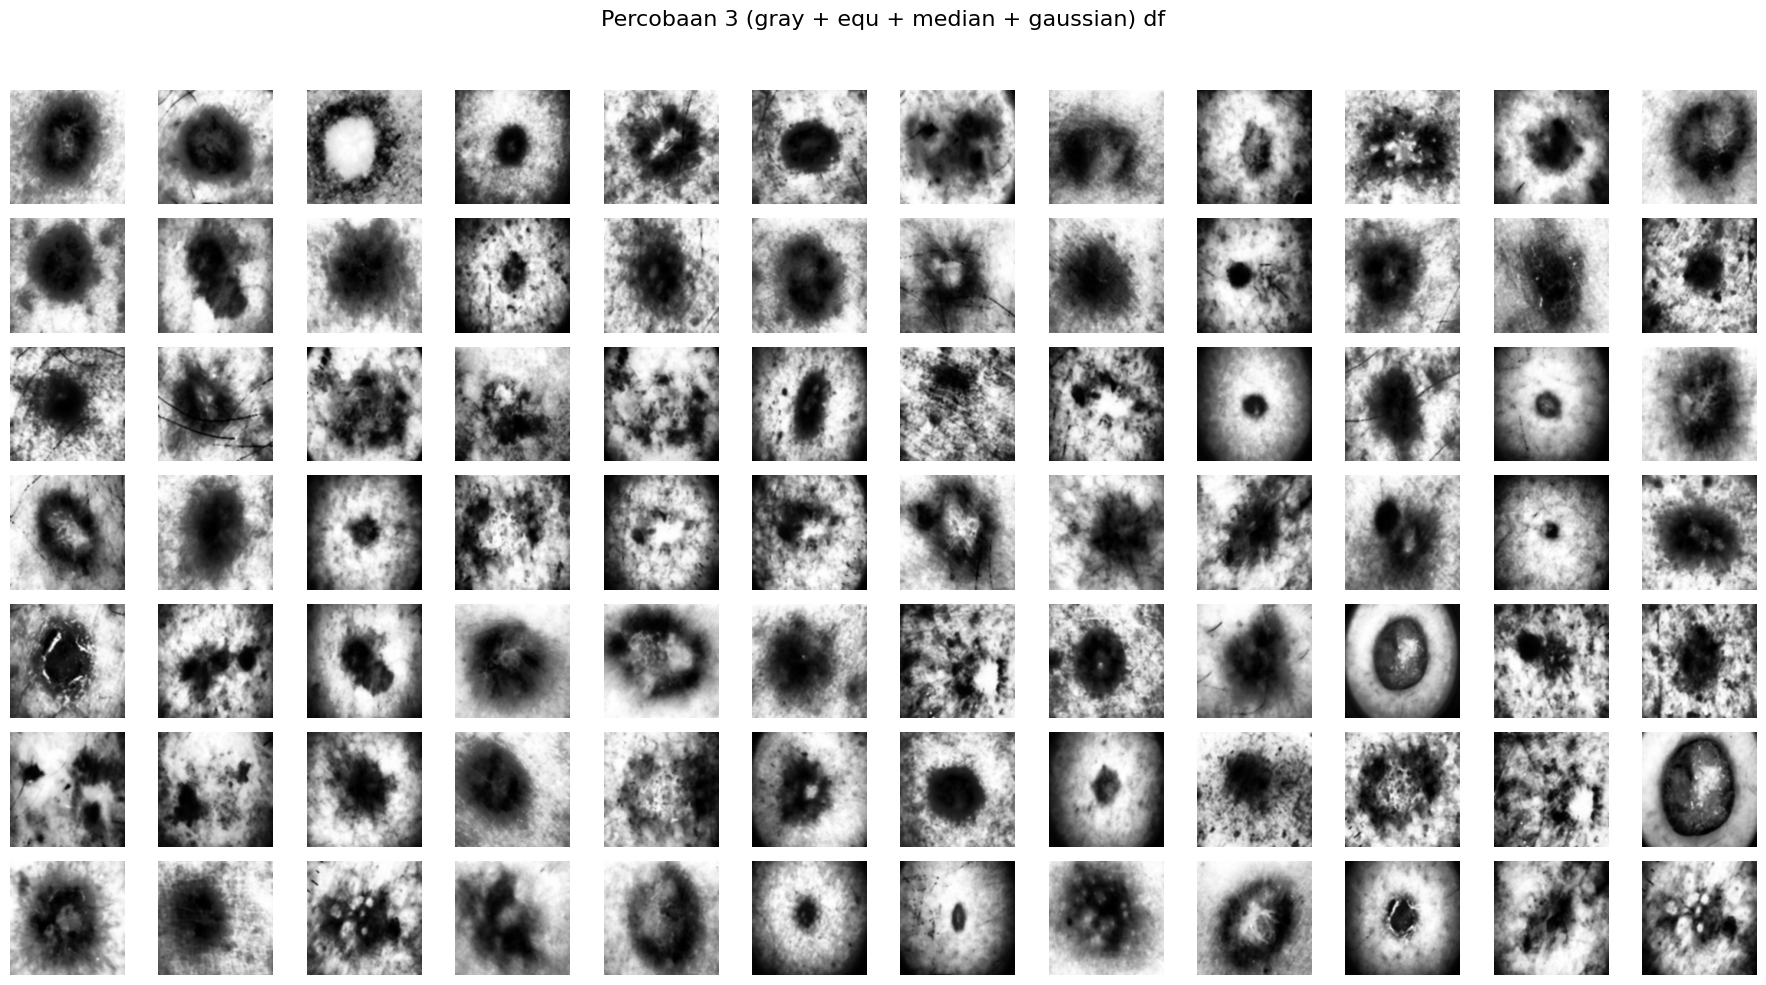

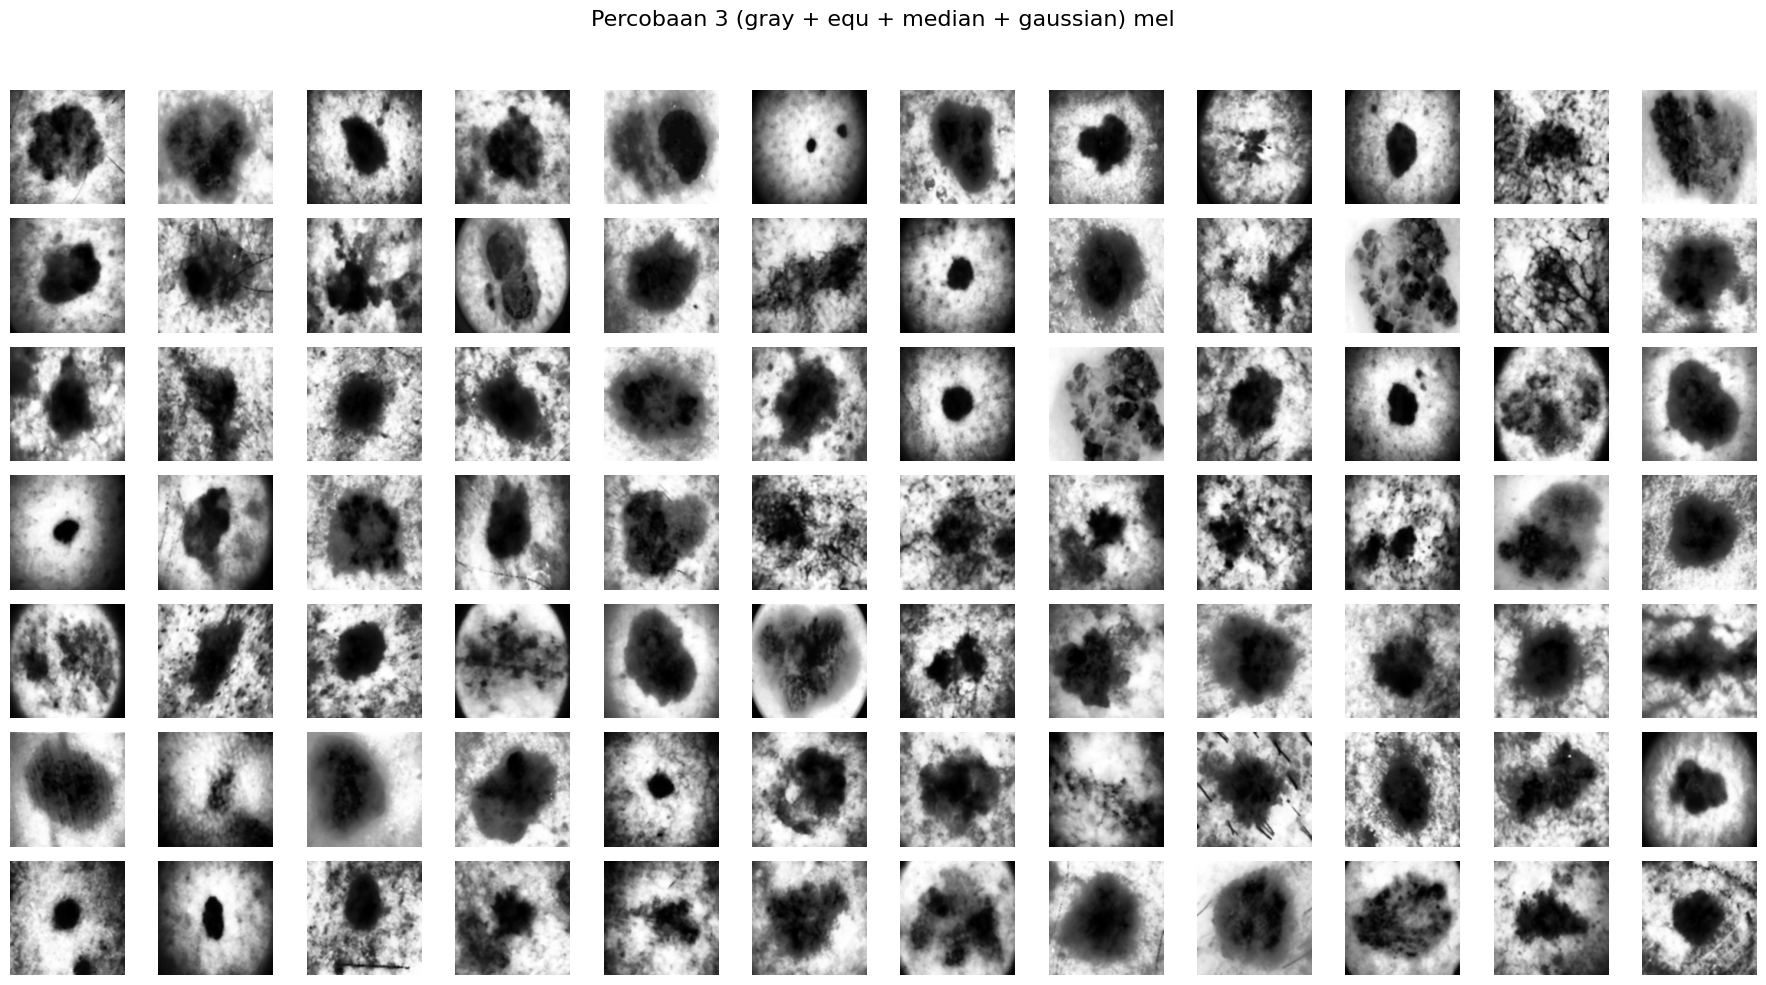

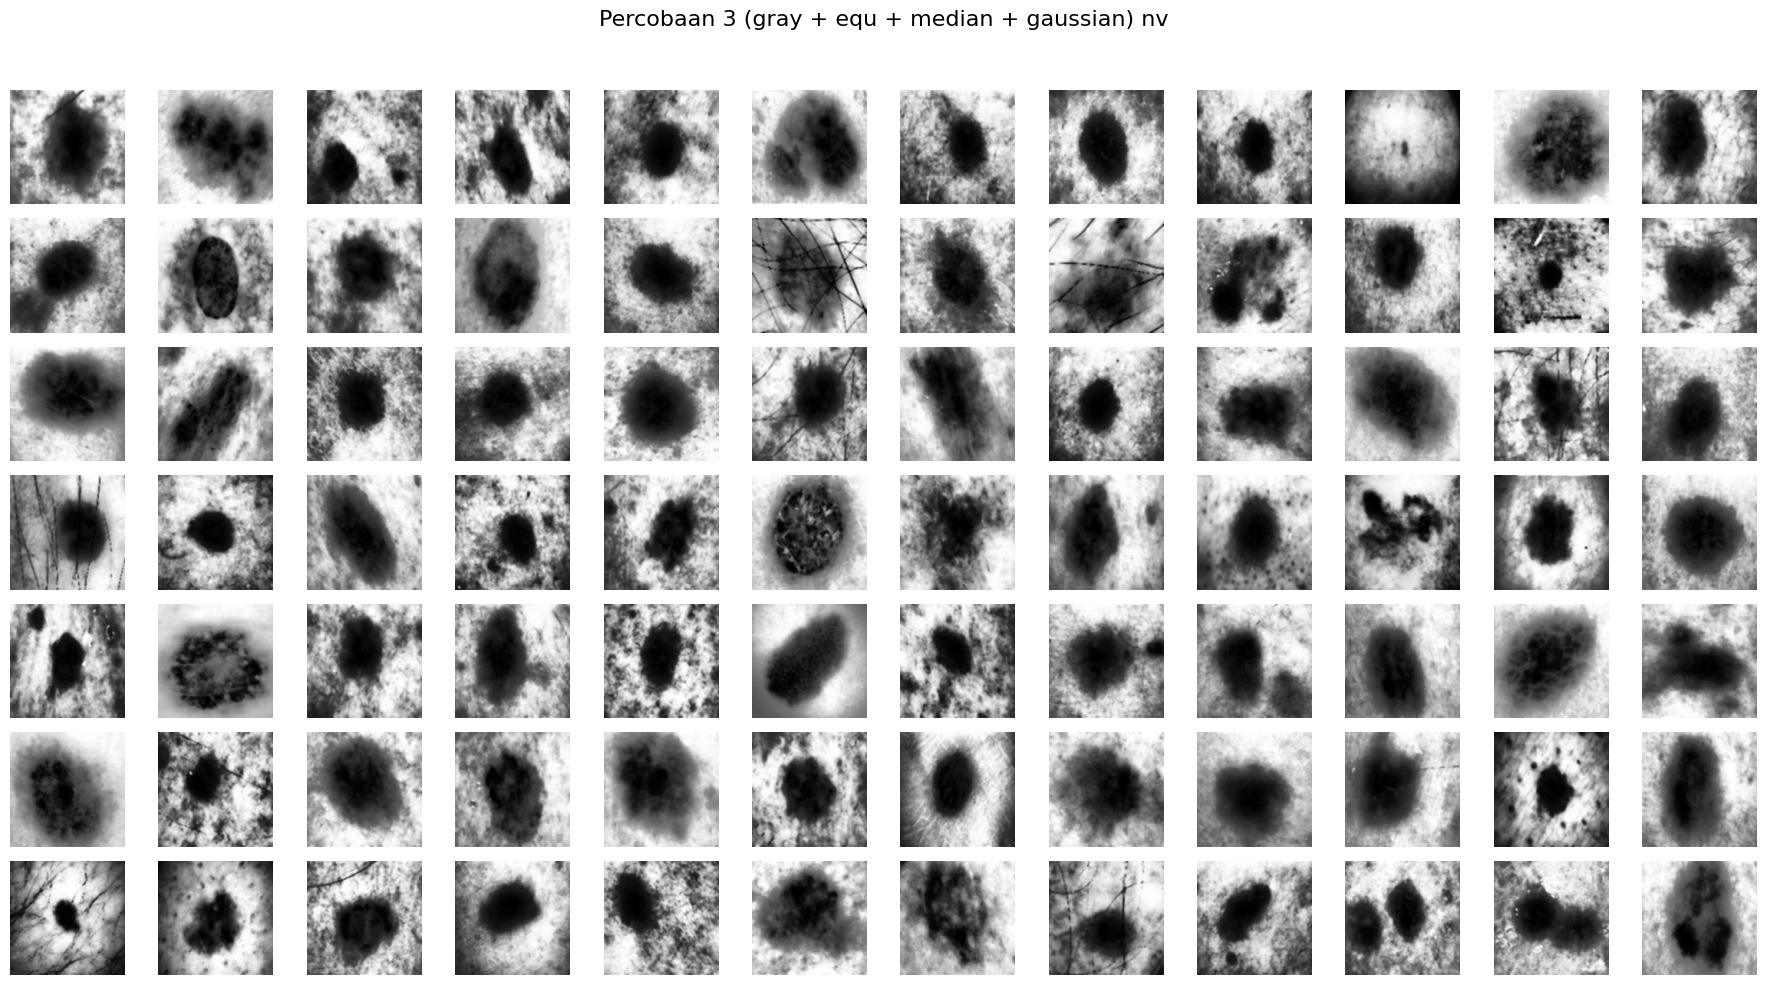

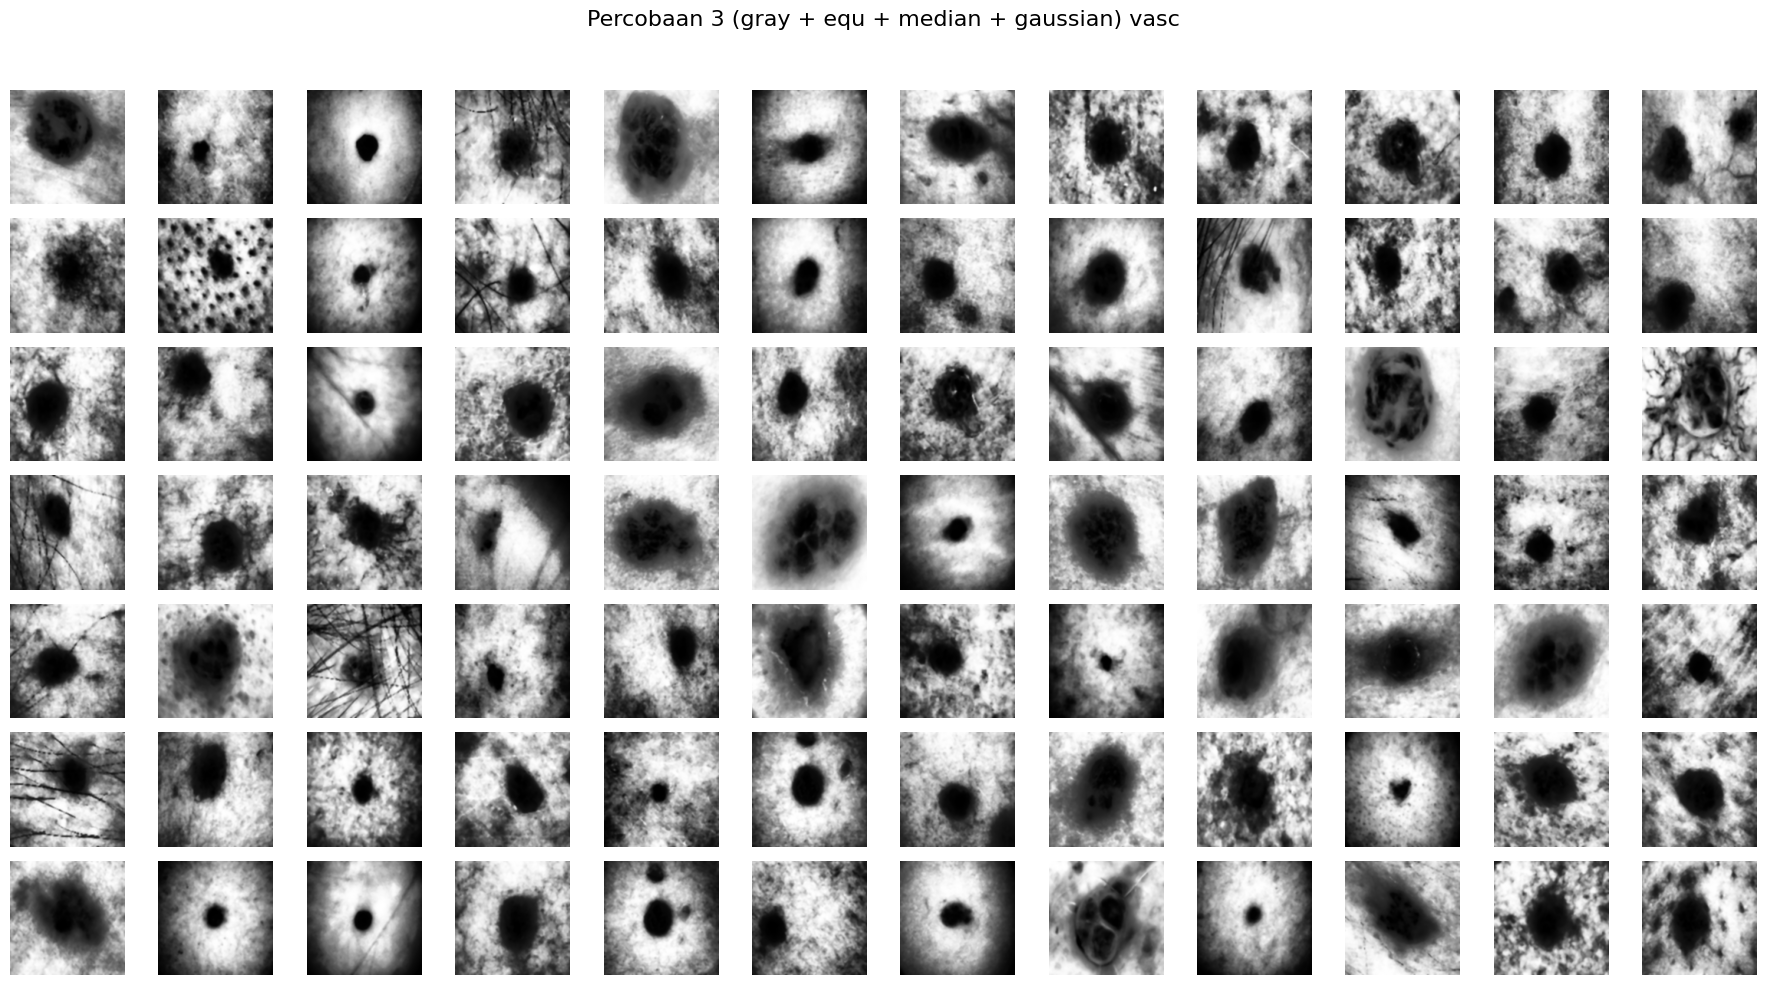

In [40]:
# Gaussian kernel 3x3
gaussian_kernel = (1/16) * np.array([[1, 2, 1],
                                     [2, 4, 2],
                                     [1, 2, 1]])

def percobaan3(gray):
    img_eq = histogram_equalization(gray)
    img_median = filter_median(img_eq, np.ones((3, 3), dtype=np.uint8))
    img_gaus = filter_image(img_median, gaussian_kernel)
    return img_gaus

dataPreprocessed = [percobaan3(img).astype(np.uint8) for img in data]  

unique_labels = sorted(set(labels))

for label in unique_labels:
    idxs = [j for j, l in enumerate(labels) if l == label]
    n_imgs = len(idxs)
    n_rows, n_cols = 7, 12
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 10))
    fig.suptitle(f'Percobaan 3 (gray + equ + median + gaussian) {label}', fontsize=16)
    
    for k in range(n_rows * n_cols):
        row = k // n_cols
        col = k % n_cols
        ax = axs[row][col]
        if k < n_imgs:
            ax.imshow(dataPreprocessed[idxs[k]], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


## Ekstraksi Fitur

In [41]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    
    return glcm

In [42]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [43]:
# Fungsi ekstraksi fitur untuk list citra
def ekstrak_fitur_glcm(data, nama_prepro):
    fitur_list = []
    for img in data:
        img_u8 = img.astype(np.uint8)
        m = glcm(img_u8, 0)  # derajat 0
        
        fitur = {
            'contrast': contrast(m),
            'correlation': correlation(m),
            'energy': energy(m),
            'homogeneity': homogenity(m),
            'dissimilarity': dissimilarity(m),
            'ASM': ASM(m),
            'entropy': entropyGlcm(m)
        }
        fitur_list.append(fitur)

    df = pd.DataFrame(fitur_list)
    df['tahap'] = nama_prepro
    return df

df2 = ekstrak_fitur_glcm(dataPreprocessed, 'percobaan6')
display(df2)

contrast  correlation    energy  homogeneity  dissimilarity       ASM  \
0      74.611409     0.993042  0.015566     0.183236       6.296421  0.000242   
1      83.836152     0.992188  0.018270     0.213016       6.415213  0.000334   
2      96.383893     0.990866  0.014522     0.173834       7.012438  0.000211   
3      65.027606     0.994053  0.016399     0.220224       5.562371  0.000269   
4     121.554541     0.988334  0.015413     0.178546       7.603490  0.000238   
...          ...          ...       ...          ...            ...       ...   
1252  111.089128     0.989744  0.015346     0.173210       7.463356  0.000236   
1253   48.087383     0.995691  0.017721     0.203667       5.005593  0.000314   
1254   54.695660     0.995125  0.018598     0.229592       5.140313  0.000346   
1255   98.310828     0.990904  0.016700     0.212088       6.575705  0.000279   
1256  205.218255     0.979326  0.012592     0.126093      10.563669  0.000159   

       entropy       tahap  
0     8.767102  percobaan6  
1     8.647715  percobaan6  
2     8.843705  percobaan6  
3     8.642550  percobaan6  
4     8.846445  percobaan6  
...        ...         ...  
1252  8.821670  percobaan6  
1253  8.479972  percobaan6  
1254  8.469747  percobaan6  
1255  8.710763  percobaan6  
1256  9.179961  percobaan6  

[1257 rows x 8 columns]

In [44]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)



## Hasil Ekstraksi to CSV

In [45]:
features = []

for i in range(len(dataPreprocessed)):
    fitur = [
        contrast(Derajat0[i]), contrast(Derajat45[i]), contrast(Derajat90[i]), contrast(Derajat135[i]),
        dissimilarity(Derajat0[i]), dissimilarity(Derajat45[i]), dissimilarity(Derajat90[i]), dissimilarity(Derajat135[i]),
        homogenity(Derajat0[i]), homogenity(Derajat45[i]), homogenity(Derajat90[i]), homogenity(Derajat135[i]),
        entropyGlcm(Derajat0[i]), entropyGlcm(Derajat45[i]), entropyGlcm(Derajat90[i]), entropyGlcm(Derajat135[i]),
        ASM(Derajat0[i]), ASM(Derajat45[i]), ASM(Derajat90[i]), ASM(Derajat135[i]),
        energy(Derajat0[i]), energy(Derajat45[i]), energy(Derajat90[i]), energy(Derajat135[i]),
        correlation(Derajat0[i]), correlation(Derajat45[i]), correlation(Derajat90[i]), correlation(Derajat135[i]),
    ]
    features.append(fitur)

# Buat dataframe
columns = [
    "contrast_0", "contrast_45", "contrast_90", "contrast_135",
    "dissimilarity_0", "dissimilarity_45", "dissimilarity_90", "dissimilarity_135",
    "homogeneity_0", "homogeneity_45", "homogeneity_90", "homogeneity_135",
    "entropy_0", "entropy_45", "entropy_90", "entropy_135",
    "ASM_0", "ASM_45", "ASM_90", "ASM_135",
    "energy_0", "energy_45", "energy_90", "energy_135",
    "correlation_0", "correlation_45", "correlation_90", "correlation_135"
]

df_fitur = pd.DataFrame(features, columns=columns)


In [46]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_percobaan3.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_percobaan3.csv')
hasilEkstrak


Filename  Label   Contrast0  Contrast45  Contrast90  \
0     ISIC_0024329.jpg  akiec   74.611409  131.156209   51.630336   
1     ISIC_0024418.jpg  akiec   83.836152  176.415747   79.255347   
2     ISIC_0024463.jpg  akiec   96.383893  168.610783   75.343311   
3     ISIC_0024511.jpg  akiec   65.027606   74.294852   42.054452   
4     ISIC_0024522.jpg  akiec  121.554541  245.939102  107.226890   
...                ...    ...         ...         ...         ...   
1252  ISIC_0033844.jpg   vasc  111.089128  172.539750   78.342058   
1253  ISIC_0033969.jpg   vasc   48.087383   59.553714   24.612394   
1254  ISIC_0033991.jpg   vasc   54.695660   94.054052   33.711544   
1255  ISIC_0034196.jpg   vasc   98.310828  168.780190   58.391544   
1256  ISIC_0034214.jpg   vasc  205.218255  344.162876  154.955168   

      Contrast135  Homogeneity0  Homogeneity45  Homogeneity90  Homogeneity135  \
0      113.900230      0.183236       0.152206       0.222846        0.155844   
1      134.274222      0.213016       0.165577       0.232241        0.180101   
2      162.811540      0.173834       0.134850       0.190706        0.141362   
3      130.420927      0.220224       0.209834       0.254779        0.172842   
4      188.497095      0.178546       0.136115       0.194394        0.153363   
...           ...           ...            ...            ...             ...   
1252   192.436467      0.173210       0.145540       0.205171        0.147520   
1253    83.519481      0.203667       0.200173       0.295896        0.189344   
1254    76.691500      0.229592       0.191909       0.284263        0.199093   
1255   135.554795      0.212088       0.170355       0.253152        0.185379   
1256   350.044007      0.126093       0.101768       0.137364        0.103841   

      ...     ASM90    ASM135   Energy0  Energy45  Energy90  Energy135  \
0     ...  0.000285  0.000201  0.015566  0.013809  0.016890   0.014191   
1     ...  0.000379  0.000290  0.018270  0.015820  0.019472   0.017043   
2     ...  0.000232  0.000173  0.014522  0.012792  0.015224   0.013167   
3     ...  0.000320  0.000206  0.016399  0.015921  0.017882   0.014341   
4     ...  0.000254  0.000195  0.015413  0.013265  0.015930   0.013973   
...   ...       ...       ...       ...       ...       ...        ...   
1252  ...  0.000278  0.000191  0.015346  0.013791  0.016681   0.013831   
1253  ...  0.000412  0.000246  0.017721  0.016531  0.020301   0.015694   
1254  ...  0.000430  0.000289  0.018598  0.016430  0.020729   0.017000   
1255  ...  0.000348  0.000246  0.016700  0.014787  0.018663   0.015679   
1256  ...  0.000177  0.000128  0.012592  0.011465  0.013304   0.011331   

      Correlation0  Correlation45  Correlation90  Correlation135  
0         0.993042       0.987767       0.995199        0.989376  
1         0.992188       0.983591       0.992630        0.987510  
2         0.990866       0.984025       0.992844        0.984575  
3         0.994053       0.993208       0.996169        0.988079  
4         0.988334       0.976413       0.989738        0.981922  
...            ...            ...            ...             ...  
1252      0.989744       0.984062       0.992770        0.982224  
1253      0.995691       0.994660       0.997800        0.992512  
1254      0.995125       0.991638       0.997001        0.993182  
1255      0.990904       0.984451       0.994630        0.987512  
1256      0.979326       0.965332       0.984365        0.964738  

[1257 rows x 30 columns]

## Feature Selection

### Correlation

<Axes: >

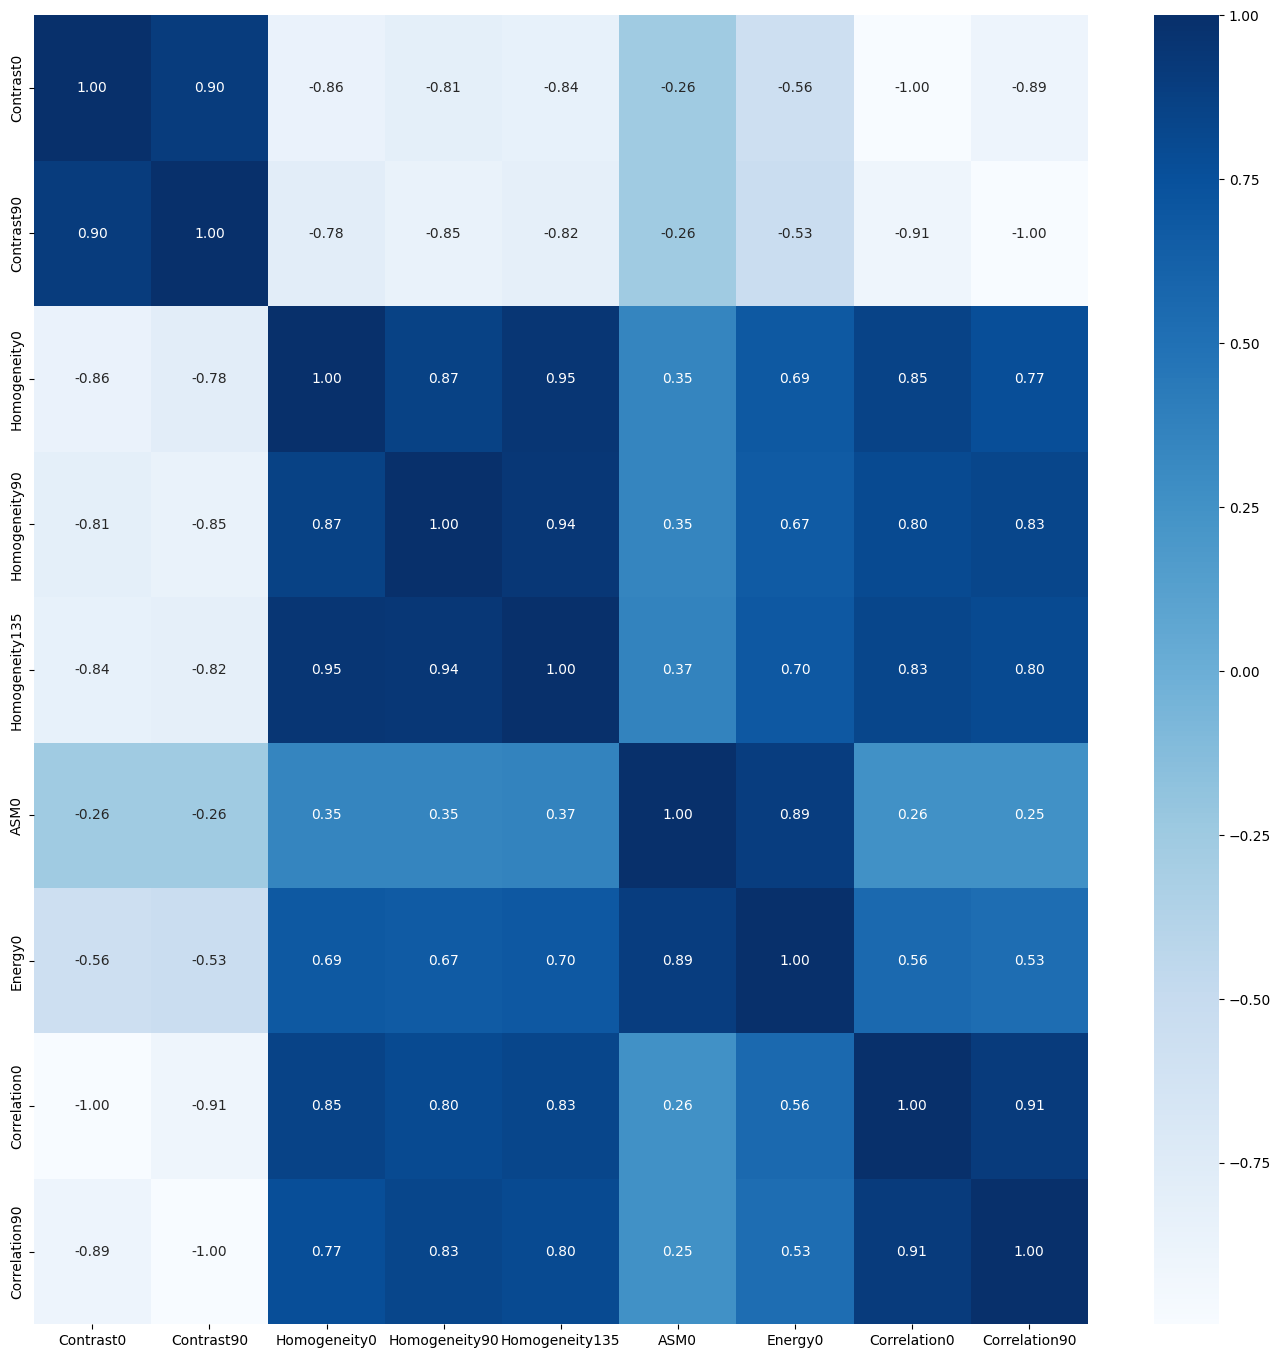

In [47]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [48]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1005, 9)
(252, 9)
(1005,)
(252,)


## Feature Normalization

In [49]:
# normalisasi mean std (Standardization / Z-score normalization)
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [50]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [51]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

       akiec       0.85      0.96      0.90       160
         bcc       0.89      0.92      0.91       153
         bkl       0.92      0.96      0.93       158
          df       0.92      0.90      0.91        93
         mel       0.93      0.93      0.93       170
          nv       0.92      0.85      0.89       156
        vasc       0.94      0.79      0.86       115

    accuracy                           0.91      1005
   macro avg       0.91      0.90      0.90      1005
weighted avg       0.91      0.91      0.91      1005

[[153   3   0   0   1   1   2]
 [  8 141   1   0   0   1   2]
 [  4   2 151   0   0   1   0]
 [  5   1   2  84   0   1   0]
 [  3   3   3   3 158   0   0]
 [  3   2   6   2   8 133   2]
 [  5   6   2   2   2   7  91]]
Accuracy: 0.9064676616915422

------Testing Set------
              precision    recall  f1-score   support

       akiec       0.31      0.50      0.38        

### Train SVM Classifier

In [52]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

       akiec       0.29      0.64      0.40       160
         bcc       0.23      0.07      0.11       153
         bkl       0.35      0.17      0.23       158
          df       0.00      0.00      0.00        93
         mel       0.26      0.49      0.34       170
          nv       0.38      0.47      0.42       156
        vasc       0.45      0.04      0.08       115

    accuracy                           0.30      1005
   macro avg       0.28      0.27      0.23      1005
weighted avg       0.29      0.30      0.25      1005

[[102   8   9   0  29  12   0]
 [ 74  11  10   0  43  14   1]
 [ 61   6  27   1  38  23   2]
 [ 31  11   4   0  37   9   1]
 [ 42   4  10   1  84  29   0]
 [ 19   5  10   1  45  74   2]
 [ 25   2   8   0  42  33   5]]
Accuracy: 0.30149253731343284

------Testing Set------
              precision    recall  f1-score   support

       akiec       0.30      0.72      0.43      

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

### Train KNN Classifier

In [53]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

       akiec       0.43      0.71      0.54       160
         bcc       0.42      0.48      0.45       153
         bkl       0.53      0.49      0.51       158
          df       0.45      0.31      0.37        93
         mel       0.46      0.46      0.46       170
          nv       0.58      0.46      0.51       156
        vasc       0.50      0.30      0.38       115

    accuracy                           0.47      1005
   macro avg       0.48      0.46      0.46      1005
weighted avg       0.48      0.47      0.47      1005

[[113  17   9   3   8   7   3]
 [ 39  73  10   3  11   7  10]
 [ 33  21  77   3  13   8   3]
 [ 24  13  10  29  12   1   4]
 [ 20  25  20  12  78   9   6]
 [ 21  13   8   5  29  71   9]
 [ 11  11  12   9  17  20  35]]
Accuracy: 0.4736318407960199

------Testing Set------
              precision    recall  f1-score   support

       akiec       0.27      0.57      0.37       

## Evaluasi Dengan Confussion Matrix

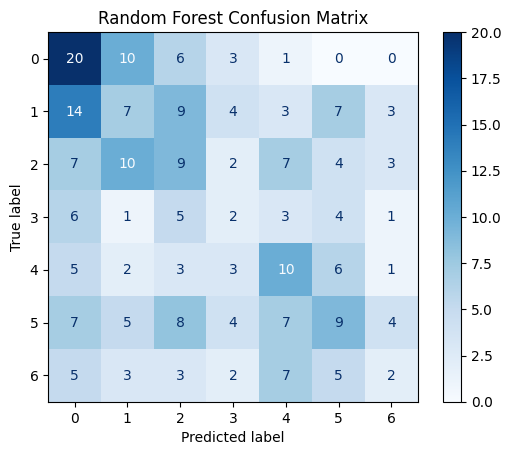

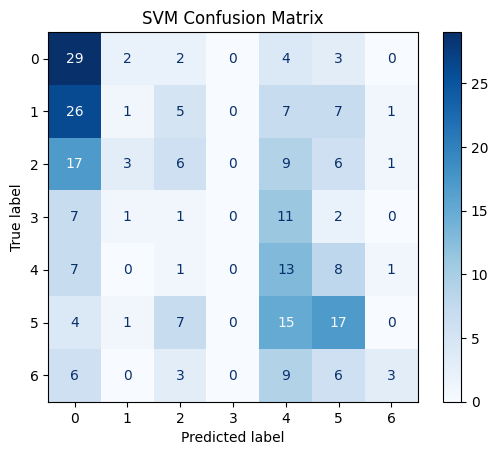

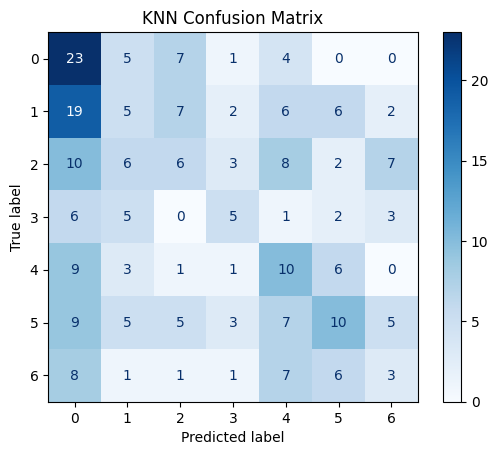

In [54]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")